# Prevendo resultados das partidas do jogo Mobile Legends: Bang Bang

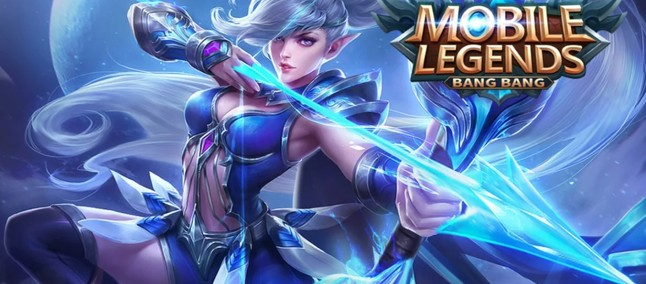

## Importação das bibliotecas necessárias

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from datetime import datetime
from sklearn import preprocessing
#!pip install pandas-profiling[notebook,html]
#from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Normalizer, LabelEncoder

In [46]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Set up the matplotlib figurea
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

## EDA / Pré-processamento, limpeza dos dados, construção de features

In [47]:
#Leitura dos datasets
summary = pd.read_csv("https://raw.githubusercontent.com/cintiadantas20/Projeto-Tera/main/summary.csv") 
ganhadores = pd.read_csv("https://raw.githubusercontent.com/cintiadantas20/Projeto-Tera/main/Ganhadores%20para%20summary.csv")

In [48]:
summary.head()

,Unnamed: 0,id,game,team_name,total_kills,total_assists,total_deaths,total_gold,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy
0,0,https://ph-mpl.com/data/match/blck-bren-20220305,game1,BREN,7,12,15,"66,957","2,746","220,776","9,054",12,13,2,3,5
1,1,https://ph-mpl.com/data/match/blck-bren-20220305,game1,BLCK,15,37,7,"72,561","2,975","263,412","10,802",8,15,2,0,9
2,0,https://ph-mpl.com/data/match/blck-bren-20220305,game2,BREN,8,17,18,"69,330","2,788","284,719","11,449",9,5,2,3,5
3,1,https://ph-mpl.com/data/match/blck-bren-20220305,game2,BLCK,18,46,8,"74,403","2,992","361,052","14,519",13,18,2,0,9
4,0,https://ph-mpl.com/data/match/blck-bren-20220402,game1,BREN,21,42,13,"52,672","3,523","259,458","17,355",11,12,2,3,9


In [49]:
summary.shape

(318, 16)

In [50]:
ganhadores.head()

,Unnamed: 0,Unnamed: 0.1,id,game,team_name,week,date,hour,duration,winner,mvp
0,0,0,https://ph-mpl.com/data/match/blck-onic-20220218,game1,ONIC,1,2022-02-18,18:00:00,14:01,1,Kairi.
1,1,1,https://ph-mpl.com/data/match/blck-onic-20220218,game1,BLCK,1,2022-02-18,18:00:00,14:01,0,Kairi.
2,2,0,https://ph-mpl.com/data/match/blck-onic-20220218,game2,ONIC,1,2022-02-18,18:00:00,27:04,0,OHEB
3,3,1,https://ph-mpl.com/data/match/blck-onic-20220218,game2,BLCK,1,2022-02-18,18:00:00,27:04,1,OHEB
4,4,0,https://ph-mpl.com/data/match/blck-onic-20220218,game3,ONIC,1,2022-02-18,18:00:00,23:56,1,Kairi.


In [51]:
ganhadores.shape

(318, 11)

In [52]:
#Junção à esquerda dos dois datasets pelas colunas id, game e team_name
summary_merged = pd.merge(ganhadores, summary, how="left", on=["id", "game", "team_name"])
summary_merged.reset_index()
# Primeiras 10 linhas do conjunto de dados
summary_merged.head(10)

,Unnamed: 0_x,Unnamed: 0.1,id,game,team_name,week,date,hour,duration,winner,...,total_deaths,total_gold,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy
0,0,0,https://ph-mpl.com/data/match/blck-onic-20220218,game1,ONIC,1,2022-02-18,18:00:00,14:01,1,...,6,"48,904","3,488","152,064","10,848",10,11,2,3,8
1,1,1,https://ph-mpl.com/data/match/blck-onic-20220218,game1,BLCK,1,2022-02-18,18:00:00,14:01,0,...,14,"37,033","2,642","78,324","5,587",4,4,0,0,2
2,2,0,https://ph-mpl.com/data/match/blck-onic-20220218,game2,ONIC,1,2022-02-18,18:00:00,27:04,0,...,12,"73,280","2,707","309,702","11,442",11,11,0,2,4
3,3,1,https://ph-mpl.com/data/match/blck-onic-20220218,game2,BLCK,1,2022-02-18,18:00:00,27:04,1,...,12,"79,895","2,951","251,501","9,291",16,18,4,0,9
4,4,0,https://ph-mpl.com/data/match/blck-onic-20220218,game3,ONIC,1,2022-02-18,18:00:00,23:56,1,...,12,"73,464","3,069","336,715","14,068",14,17,3,2,9
5,5,1,https://ph-mpl.com/data/match/blck-onic-20220218,game3,BLCK,1,2022-02-18,18:00:00,23:56,0,...,22,"69,247","2,893","262,029","10,948",11,10,1,0,3
6,6,0,https://ph-mpl.com/data/match/omg-tnc-20220218,game1,TNC,1,2022-02-18,20:00:00,15:54,1,...,3,"52,380","3,294","171,027","10,756",10,9,2,3,7
7,7,1,https://ph-mpl.com/data/match/omg-tnc-20220218,game1,OMG,1,2022-02-18,20:00:00,15:54,0,...,19,"41,119","2,586","156,638","9,851",5,7,0,0,4
8,8,0,https://ph-mpl.com/data/match/omg-tnc-20220218,game2,TNC,1,2022-02-18,20:00:00,17:56,1,...,6,"55,679","3,104","173,297","9,663",7,9,2,2,7
9,9,1,https://ph-mpl.com/data/match/omg-tnc-20220218,game2,OMG,1,2022-02-18,20:00:00,17:56,0,...,12,"47,939","2,673","135,343","7,547",9,9,0,1,4


In [53]:
# Últimas 10 linhas do conjunto de dados
summary_merged.tail(10)

,Unnamed: 0_x,Unnamed: 0.1,id,game,team_name,week,date,hour,duration,winner,...,total_deaths,total_gold,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy
308,308,0,https://ph-mpl.com/data/match/rsg-omg-20220501,game1,RSG,PLAYOFFS,2022-05-01,19:00:00,18:35,1,...,8,"60,245","3,241","237,757","12,794",8,10,2,3,8
309,309,1,https://ph-mpl.com/data/match/rsg-omg-20220501,game1,OMG,PLAYOFFS,2022-05-01,19:00:00,18:35,0,...,22,"49,387","2,657","121,214","6,522",7,6,1,0,4
310,310,0,https://ph-mpl.com/data/match/rsg-omg-20220501,game2,RSG,PLAYOFFS,2022-05-01,19:00:00,13:37,0,...,2,"34,441","2,529","80,832","5,936",6,6,0,1,1
311,311,1,https://ph-mpl.com/data/match/rsg-omg-20220501,game2,OMG,PLAYOFFS,2022-05-01,19:00:00,13:37,1,...,0,"44,377","3,259","111,972","8,223",7,9,2,2,8
312,312,0,https://ph-mpl.com/data/match/rsg-omg-20220501,game3,OMG,PLAYOFFS,2022-05-01,19:00:00,18:10,0,...,15,"48,948","2,694","120,871","6,653",8,7,0,2,2
313,313,1,https://ph-mpl.com/data/match/rsg-omg-20220501,game3,RSG,PLAYOFFS,2022-05-01,19:00:00,18:10,1,...,7,"58,771","3,235","162,415","8,940",9,12,3,1,8
314,314,0,https://ph-mpl.com/data/match/rsg-omg-20220501,game4,OMG,PLAYOFFS,2022-05-01,19:00:00,18:36,0,...,13,"49,840","2,679","195,588","10,515",10,9,0,1,2
315,315,1,https://ph-mpl.com/data/match/rsg-omg-20220501,game4,RSG,PLAYOFFS,2022-05-01,19:00:00,18:36,1,...,8,"59,141","3,179","221,725","11,920",8,10,3,2,7
316,316,0,https://ph-mpl.com/data/match/rsg-omg-20220501,game5,OMG,PLAYOFFS,2022-05-01,19:00:00,24:25,0,...,19,"62,451","2,559","256,008","10,492",9,8,2,2,6
317,317,1,https://ph-mpl.com/data/match/rsg-omg-20220501,game5,RSG,PLAYOFFS,2022-05-01,19:00:00,24:25,1,...,8,"71,388","2,925","297,772","12,203",11,13,2,1,9


In [54]:
# Verificando dados duplicados
summary_merged.duplicated().sum()

0

In [55]:
# Mapeamento do dataset
summary_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 317
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0_x   318 non-null    int64 
 1   Unnamed: 0.1   318 non-null    int64 
 2   id             318 non-null    object
 3   game           318 non-null    object
 4   team_name      318 non-null    object
 5   week           318 non-null    object
 6   date           318 non-null    object
 7   hour           318 non-null    object
 8   duration       318 non-null    object
 9   winner         318 non-null    int64 
 10  mvp            316 non-null    object
 11  Unnamed: 0_y   318 non-null    int64 
 12  total_kills    318 non-null    int64 
 13  total_assists  318 non-null    int64 
 14  total_deaths   318 non-null    int64 
 15  total_gold     318 non-null    object
 16  gold_min       318 non-null    object
 17  total_damage   318 non-null    object
 18  damage_min     318 non-null   

In [56]:
#Verificação dos valores nulos
summary_merged.isnull().sum()

Unnamed: 0_x     0
Unnamed: 0.1     0
id               0
game             0
team_name        0
week             0
date             0
hour             0
duration         0
winner           0
mvp              2
Unnamed: 0_y     0
total_kills      0
total_assists    0
total_deaths     0
total_gold       0
gold_min         0
total_damage     0
damage_min       0
red_buff         0
blue_buff        0
lord_kill        0
tortoise_kill    0
tower_destroy    0
dtype: int64

Apenas a coluna MVP possue valores nulos. Como não será uma coluna necessária em nossa análise, resolvemos retirá-la do dataset.

###Exclusão e transformação de algumas colunas

In [57]:
# Exclusão de colunas desnecessárias (unnamed)
summary_merged = summary_merged.drop(["Unnamed: 0_x", "Unnamed: 0.1", "Unnamed: 0_y", "mvp"], axis=1)

In [58]:
# Transformando duas colunas('date' e 'hour') em uma só, para uma melhor manipulação
summary_merged['fullDate'] = pd.to_datetime(summary_merged.date.astype(str) +' '+ summary_merged.hour.astype(str))

In [59]:
# Excluindo 'date' e 'hour' pois não são mais necessárias
summary_merged = summary_merged.drop(["date", "hour"], axis=1)

In [60]:
# Transformando a variável 'duration' para tempo em minutos para poder manipular
# Criação de lista de valores transformados
duration = summary_merged.loc[:,"duration"]
duration_min = []
for i in duration:
  minutePart = i[0:2]
  secondPart = i[3:]
  minute = int(minutePart)
  second = int(secondPart)
  sec = second/60
  timeFinal = round(minute+sec,2)
  duration_min.append(timeFinal)
print(duration_min)

[14.02, 14.02, 27.07, 27.07, 23.93, 23.93, 15.9, 15.9, 17.93, 17.93, 17.65, 17.65, 21.52, 21.52, 17.35, 17.35, 14.42, 14.42, 16.03, 16.03, 18.75, 18.75, 18.2, 18.2, 14.43, 14.43, 15.07, 15.07, 10.2, 10.2, 9.92, 9.92, 11.7, 11.7, 17.02, 17.02, 20.28, 20.28, 14.72, 14.72, 15.25, 15.25, 23.75, 23.75, 13.85, 13.85, 16.35, 16.35, 18.27, 18.27, 20.65, 20.65, 15.97, 15.97, 15.52, 15.52, 14.32, 14.32, 14.2, 14.2, 14.37, 14.37, 19.35, 19.35, 14.42, 14.42, 15.1, 15.1, 22.97, 22.97, 19.2, 19.2, 24.38, 24.38, 24.87, 24.87, 16.88, 16.88, 18.77, 18.77, 14.88, 14.88, 14.18, 14.18, 15.7, 15.7, 17.78, 17.78, 13.9, 13.9, 17.42, 17.42, 13.93, 13.93, 15.47, 15.47, 13.9, 13.9, 17.23, 17.23, 15.0, 15.0, 21.93, 21.93, 28.72, 28.72, 21.7, 21.7, 17.87, 17.87, 11.05, 11.05, 13.32, 13.32, 20.67, 20.67, 19.98, 19.98, 18.33, 18.33, 15.82, 15.82, 20.7, 20.7, 17.15, 17.15, 14.67, 14.67, 25.4, 25.4, 17.62, 17.62, 18.6, 18.6, 16.17, 16.17, 30.72, 30.72, 18.0, 18.0, 15.97, 15.97, 17.32, 17.32, 18.5, 18.5, 18.72, 18.72,

In [61]:
# Criação de coluna, adição ao dataset e exclusão da coluna "duration"
summary_merged['duration_min'] = duration_min
summary_merged = summary_merged.drop(["duration"], axis=1)
summary_merged.head()

,id,game,team_name,week,winner,total_kills,total_assists,total_deaths,total_gold,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy,fullDate,duration_min
0,https://ph-mpl.com/data/match/blck-onic-20220218,game1,ONIC,1,1,14,35,6,"48,904","3,488","152,064","10,848",10,11,2,3,8,2022-02-18 18:00:00,14.02
1,https://ph-mpl.com/data/match/blck-onic-20220218,game1,BLCK,1,0,6,13,14,"37,033","2,642","78,324","5,587",4,4,0,0,2,2022-02-18 18:00:00,14.02
2,https://ph-mpl.com/data/match/blck-onic-20220218,game2,ONIC,1,0,12,34,12,"73,280","2,707","309,702","11,442",11,11,0,2,4,2022-02-18 18:00:00,27.07
3,https://ph-mpl.com/data/match/blck-onic-20220218,game2,BLCK,1,1,12,24,12,"79,895","2,951","251,501","9,291",16,18,4,0,9,2022-02-18 18:00:00,27.07
4,https://ph-mpl.com/data/match/blck-onic-20220218,game3,ONIC,1,1,22,48,12,"73,464","3,069","336,715","14,068",14,17,3,2,9,2022-02-18 18:00:00,23.93


In [62]:
# Retirando a ',' para transformar os tipos das variáveis corretamente para inteiro
summary_merged['total_gold'] = summary_merged['total_gold'].map(lambda x: int( str(x).replace(',', '')))
summary_merged['gold_min'] = summary_merged['gold_min'].map(lambda x: int( str(x).replace(',', '')))
summary_merged['total_damage'] = summary_merged['total_damage'].map(lambda x: int( str(x).replace(',', '')))
summary_merged['damage_min'] = summary_merged['damage_min'].map(lambda x: int( str(x).replace(',', '')))

In [63]:
# Trocando o valor PLAYOFFS da coluna week pelo número 9 para a coluna ficar totalmente com valores inteiros
def MudarValor(x):
    if x == 'PLAYOFFS':
        x = 9
    return x

summary_merged['week'] = summary_merged['week'].apply(lambda x: MudarValor(x))

In [64]:
# Conferindo se deu certo
summary_merged['week'].tail(10)

308    9
309    9
310    9
311    9
312    9
313    9
314    9
315    9
316    9
317    9
Name: week, dtype: object

In [65]:
# Corrigindo o dtype de algumas variáveis
summary_merged.id = summary_merged.id.astype('category')
summary_merged.game = summary_merged.game.astype('category')
summary_merged.team_name = summary_merged.team_name.astype('category')
summary_merged.week = summary_merged.week.astype('int64')
summary_merged.winner = summary_merged.winner.astype('category')

In [66]:
# Verificando as colunas depois das modificações
summary_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 317
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             318 non-null    category      
 1   game           318 non-null    category      
 2   team_name      318 non-null    category      
 3   week           318 non-null    int64         
 4   winner         318 non-null    category      
 5   total_kills    318 non-null    int64         
 6   total_assists  318 non-null    int64         
 7   total_deaths   318 non-null    int64         
 8   total_gold     318 non-null    int64         
 9   gold_min       318 non-null    int64         
 10  total_damage   318 non-null    int64         
 11  damage_min     318 non-null    int64         
 12  red_buff       318 non-null    int64         
 13  blue_buff      318 non-null    int64         
 14  lord_kill      318 non-null    int64         
 15  tortoise_kill  318 non-

In [67]:
# Resumo das medidas das variáveis quantitativas:
summary_merged.describe(percentiles = [.25, .50, .75, .95, .99], include=['int64', 'float64']).round(2)

,week,total_kills,total_assists,total_deaths,total_gold,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy,duration_min
count,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00,318.00
mean,5.24,11.69,26.09,11.70,53151.01,3006.20,190291.61,10611.27,8.18,9.22,1.28,1.47,5.64,17.61
std,2.63,6.05,14.44,6.04,13235.98,317.30,74431.21,2739.53,2.62,3.51,1.16,1.14,3.13,4.22
min,1.00,0.00,0.00,0.00,23552.00,2374.00,50139.00,4537.00,2.00,2.00,0.00,0.00,0.00,9.92
25%,3.00,7.00,14.25,7.00,43854.00,2742.25,139160.50,8812.00,6.25,7.00,0.00,0.00,2.00,14.63
50%,5.00,12.00,24.00,12.00,51107.00,2991.50,179098.00,10687.50,8.00,9.00,1.00,1.00,7.00,16.90
75%,8.00,16.00,36.00,16.00,60239.25,3261.50,227970.50,12231.75,10.00,11.00,2.00,2.75,8.00,19.31
95%,9.00,22.00,50.00,22.00,79042.45,3500.60,339868.90,15519.90,12.00,15.15,3.00,3.00,9.00,25.59
99%,9.00,24.83,61.00,24.83,90082.37,3605.66,432214.14,17316.41,15.83,18.83,4.00,3.00,9.00,29.53
max,9.00,43.00,72.00,43.00,101701.00,3943.00,465428.00,20638.00,18.00,21.00,6.00,3.00,9.00,30.72


### Criação de listas das features conforme tipo

In [68]:
# Variáveis numéricas
vars_num = summary_merged.select_dtypes(include=['int', 'float']).columns.tolist()

#Variáveis categóricas
vars_cat = summary_merged.select_dtypes(exclude=['int', 'float']).columns.tolist()

In [69]:
# Organização das colunas para melhor visualização dos dados
cols = list(summary_merged.columns.values)
print(cols)

['id', 'game', 'team_name', 'week', 'winner', 'total_kills', 'total_assists', 'total_deaths', 'total_gold', 'gold_min', 'total_damage', 'damage_min', 'red_buff', 'blue_buff', 'lord_kill', 'tortoise_kill', 'tower_destroy', 'fullDate', 'duration_min']


In [70]:
summary_merged = summary_merged[['id', 
                                 'game', 
                                 'fullDate',
                                 'team_name', 
                                 'week', 
                                 'winner',
                                 'duration_min', 
                                 'total_kills', 
                                 'total_assists', 
                                 'total_deaths', 
                                 'total_gold', 
                                 'gold_min', 
                                 'total_damage', 
                                 'damage_min', 
                                 'red_buff', 
                                 'blue_buff', 
                                 'lord_kill', 
                                 'tortoise_kill', 
                                 'tower_destroy']]
summary_merged.head()

,id,game,fullDate,team_name,week,winner,duration_min,total_kills,total_assists,total_deaths,total_gold,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy
0,https://ph-mpl.com/data/match/blck-onic-20220218,game1,2022-02-18 18:00:00,ONIC,1,1,14.02,14,35,6,48904,3488,152064,10848,10,11,2,3,8
1,https://ph-mpl.com/data/match/blck-onic-20220218,game1,2022-02-18 18:00:00,BLCK,1,0,14.02,6,13,14,37033,2642,78324,5587,4,4,0,0,2
2,https://ph-mpl.com/data/match/blck-onic-20220218,game2,2022-02-18 18:00:00,ONIC,1,0,27.07,12,34,12,73280,2707,309702,11442,11,11,0,2,4
3,https://ph-mpl.com/data/match/blck-onic-20220218,game2,2022-02-18 18:00:00,BLCK,1,1,27.07,12,24,12,79895,2951,251501,9291,16,18,4,0,9
4,https://ph-mpl.com/data/match/blck-onic-20220218,game3,2022-02-18 18:00:00,ONIC,1,1,23.93,22,48,12,73464,3069,336715,14068,14,17,3,2,9


###Criando novas features (feature engineering)

- Variável sum_buffs

O que é: soma das colunas red_buff e blue_buff

Objetivo/importância: sintetizar dados de monstros que garantem vantagens ao jogador que os matam

Explicação: o red e o blue buff são os mostros mais importantes da jungle, depois da turtle e do lord. São semelhantes pois ambos garantem vantagens ao jogador que os matam e surgem no jogo simultaneamente. Entretanto, o red buff dá dano extra, lentidão ao inimigo e penetração física ou mágica, enquanto o blue buff reduz o cooldown dos poderes, o custo da mana e da energia e restaura uma percentagem de HP ao matar o inimigo


In [71]:
# Criando nova coluna com a soma de red_buff com a blue_buff
summary_merged['sum_buffs'] = summary_merged['red_buff'] + summary_merged['blue_buff']

- Variável KDA (Kills Deaths Assists)

O que é: fórmula (mortes causadas + assistências) / mortes sofridas

Objetivo/importância: medir a performance do time na partida com base nas variáveis envolvidas no cálculo

Explicação: o KDA é uma métrica individual por jogador que diz sobre sua performance na partida. Quanto maior o KDA, mais kills e assistências e menos mortes. Quanto menor, o jogador morreu mais vezes que matou e deu assistências.
Também é uma métrica histórica do jogador quanto a todas as partidas de que participou

In [72]:
# Criando nova coluna com a variável KDA: mortes causadas + assistências / mortes sofridas
# Como no cálculo existe divisão com 0 como numerador ou denominador, foi necessário criar a coluna com um for loop
kdalist = []
for i in range(len(summary_merged)):
    kda = 0
    if summary_merged['total_deaths'][i] == 0:
        kda = summary_merged['total_kills'][i] + summary_merged['total_assists'][i]
    elif summary_merged['total_kills'][i] == 0 and summary_merged['total_assists'][i] == 0:
        kda == 0
    else:
        kda = round(((summary_merged['total_kills'][i] + summary_merged['total_assists'][i]) / summary_merged['total_deaths'][i]),2)
    kdalist.append(kda)
print(kdalist)

[8.17, 1.36, 3.83, 3.0, 5.83, 1.95, 16.33, 0.47, 6.83, 1.58, 5.1, 2.07, 0.75, 12.0, 5.46, 1.9, 1.08, 9.4, 9.0, 1.13, 2.54, 2.75, 0.67, 10.17, 10.33, 1.0, 21.0, 0.63, 34.0, 0.31, 19.5, 0.64, 0.59, 13.0, 1.57, 6.38, 6.0, 2.5, 44.0, 0.27, 0.83, 9.0, 2.77, 2.73, 12.25, 0.92, 7.6, 1.33, 1.11, 10.33, 9.0, 0.94, 5.33, 1.73, 3.54, 3.92, 11.67, 0.95, 5.5, 1.67, 0.2, 46.0, 3.5, 3.22, 1.78, 6.0, 1.82, 4.43, 2.58, 4.33, 5.09, 2.13, 1.27, 7.43, 1.39, 8.0, 1.42, 6.33, 5.5, 2.42, 9.0, 1.36, 10.4, 1.13, 1.23, 8.4, 7.29, 1.56, 40.0, 0.31, 21, 0, 21.0, 0.43, 1.2, 10.5, 4.83, 2.22, 0.25, 20.0, 7.0, 1.36, 3.21, 2.53, 3.5, 3.48, 3.29, 3.67, 2.73, 4.26, 17.0, 0.47, 10.0, 1.0, 1.0, 7.5, 32, 0, 8.4, 1.23, 8.5, 1.4, 3.5, 2.36, 2.0, 5.0, 10.75, 1.21, 2.0, 4.6, 1.0, 5.86, 2.88, 3.93, 5.29, 2.18, 1.87, 5.0, 1.46, 6.67, 1.0, 10.4, 0, 25, 10.5, 1.17, 10.0, 1.28, 5.55, 1.79, 1.79, 6.08, 6.09, 1.52, 9.8, 0.75, 24.0, 0.64, 2.22, 4.4, 1.21, 9.4, 4.27, 2.25, 2.11, 4.43, 13.83, 0.88, 9.0, 1.0, 6.2, 1.56, 4.0, 2.31, 1.73,

In [73]:
# Criando nova coluna para a variável KDA
summary_merged['KDA'] = kdalist
summary_merged.head()

,id,game,fullDate,team_name,week,winner,duration_min,total_kills,total_assists,total_deaths,...,gold_min,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy,sum_buffs,KDA
0,https://ph-mpl.com/data/match/blck-onic-20220218,game1,2022-02-18 18:00:00,ONIC,1,1,14.02,14,35,6,...,3488,152064,10848,10,11,2,3,8,21,8.17
1,https://ph-mpl.com/data/match/blck-onic-20220218,game1,2022-02-18 18:00:00,BLCK,1,0,14.02,6,13,14,...,2642,78324,5587,4,4,0,0,2,8,1.36
2,https://ph-mpl.com/data/match/blck-onic-20220218,game2,2022-02-18 18:00:00,ONIC,1,0,27.07,12,34,12,...,2707,309702,11442,11,11,0,2,4,22,3.83
3,https://ph-mpl.com/data/match/blck-onic-20220218,game2,2022-02-18 18:00:00,BLCK,1,1,27.07,12,24,12,...,2951,251501,9291,16,18,4,0,9,34,3.00
4,https://ph-mpl.com/data/match/blck-onic-20220218,game3,2022-02-18 18:00:00,ONIC,1,1,23.93,22,48,12,...,3069,336715,14068,14,17,3,2,9,31,5.83


In [74]:
kda1 = summary_merged['KDA'].tolist()
print(kda1)

[8.17, 1.36, 3.83, 3.0, 5.83, 1.95, 16.33, 0.47, 6.83, 1.58, 5.1, 2.07, 0.75, 12.0, 5.46, 1.9, 1.08, 9.4, 9.0, 1.13, 2.54, 2.75, 0.67, 10.17, 10.33, 1.0, 21.0, 0.63, 34.0, 0.31, 19.5, 0.64, 0.59, 13.0, 1.57, 6.38, 6.0, 2.5, 44.0, 0.27, 0.83, 9.0, 2.77, 2.73, 12.25, 0.92, 7.6, 1.33, 1.11, 10.33, 9.0, 0.94, 5.33, 1.73, 3.54, 3.92, 11.67, 0.95, 5.5, 1.67, 0.2, 46.0, 3.5, 3.22, 1.78, 6.0, 1.82, 4.43, 2.58, 4.33, 5.09, 2.13, 1.27, 7.43, 1.39, 8.0, 1.42, 6.33, 5.5, 2.42, 9.0, 1.36, 10.4, 1.13, 1.23, 8.4, 7.29, 1.56, 40.0, 0.31, 21.0, 0.0, 21.0, 0.43, 1.2, 10.5, 4.83, 2.22, 0.25, 20.0, 7.0, 1.36, 3.21, 2.53, 3.5, 3.48, 3.29, 3.67, 2.73, 4.26, 17.0, 0.47, 10.0, 1.0, 1.0, 7.5, 32.0, 0.0, 8.4, 1.23, 8.5, 1.4, 3.5, 2.36, 2.0, 5.0, 10.75, 1.21, 2.0, 4.6, 1.0, 5.86, 2.88, 3.93, 5.29, 2.18, 1.87, 5.0, 1.46, 6.67, 1.0, 10.4, 0.0, 25.0, 10.5, 1.17, 10.0, 1.28, 5.55, 1.79, 1.79, 6.08, 6.09, 1.52, 9.8, 0.75, 24.0, 0.64, 2.22, 4.4, 1.21, 9.4, 4.27, 2.25, 2.11, 4.43, 13.83, 0.88, 9.0, 1.0, 6.2, 1.56, 4.0,

- Variável assists_taken

O que é: valor das assistências realizadas pelo outro time na partida

Objetivo/importância: demonstrar as assistências sofridas pelo time, semelhante às mortes sofridas (deaths)

Explicação: a assistência é a participação na morte de algum inimigo, mas sem que o jogador seja o responsável pelo último golpe. Assim como as mortes causadas e as sofridas, criamos a variável das assistências sofridas

In [75]:
# Criando nova coluna com a variável de assistências feitas contra o time, pelo time inimigo
assislist = []
for idx, i in enumerate(summary_merged['total_assists'][0:318:2]):
    assislist.insert(idx+1,i)
    assislist.insert(idx,summary_merged['total_assists'][idx+1])
print(assislist)
summary_merged['assists_taken'] = assislist
summary_merged.head()

[13, 34, 24, 48, 31, 30, 6, 29, 13, 37, 19, 6, 24, 50, 27, 8, 35, 30, 12, 21, 20, 6, 43, 23, 5, 44, 9, 21, 3, 28, 5, 7, 35, 14, 37, 50, 29, 33, 2, 6, 24, 25, 17, 36, 8, 26, 11, 14, 44, 37, 10, 33, 17, 33, 38, 50, 13, 21, 14, 2, 31, 26, 19, 11, 21, 13, 20, 34, 46, 41, 21, 12, 37, 17, 46, 11, 26, 47, 34, 25, 11, 37, 12, 11, 29, 35, 18, 27, 3, 14, 0, 28, 4, 8, 32, 20, 14, 1, 28, 48, 20, 30, 24, 61, 56, 41, 38, 41, 59, 36, 4, 14, 4, 10, 42, 23, 0, 29, 11, 24, 10, 35, 19, 17, 23, 29, 13, 22, 30, 9, 25, 34, 42, 26, 17, 19, 30, 13, 27, 11, 36, 0, 17, 45, 15, 42, 17, 42, 23, 22, 54, 46, 21, 33, 7, 34, 7, 25, 48, 35, 22, 24, 11, 0, 50, 31, 45, 44, 42, 37, 11, 24, 6, 21, 42, 34, 16, 37, 47, 50, 63, 34, 29, 52, 41, 28, 40, 6, 34, 32, 24, 31, 24, 19, 6, 25, 8, 23, 23, 35, 32, 12, 11, 54, 24, 14, 25, 22, 50, 50, 20, 25, 42, 61, 44, 31, 23, 6, 50, 38, 64, 28, 15, 1, 20, 17, 44, 22, 12, 15, 10, 26, 28, 22, 30, 59, 26, 35, 12, 25, 34, 33, 46, 22, 42, 42, 45, 0, 11, 13, 19, 26, 34, 9, 22, 29, 17, 35, 2

,id,game,fullDate,team_name,week,winner,duration_min,total_kills,total_assists,total_deaths,...,total_damage,damage_min,red_buff,blue_buff,lord_kill,tortoise_kill,tower_destroy,sum_buffs,KDA,assists_taken
0,https://ph-mpl.com/data/match/blck-onic-20220218,game1,2022-02-18 18:00:00,ONIC,1,1,14.02,14,35,6,...,152064,10848,10,11,2,3,8,21,8.17,13
1,https://ph-mpl.com/data/match/blck-onic-20220218,game1,2022-02-18 18:00:00,BLCK,1,0,14.02,6,13,14,...,78324,5587,4,4,0,0,2,8,1.36,34
2,https://ph-mpl.com/data/match/blck-onic-20220218,game2,2022-02-18 18:00:00,ONIC,1,0,27.07,12,34,12,...,309702,11442,11,11,0,2,4,22,3.83,24
3,https://ph-mpl.com/data/match/blck-onic-20220218,game2,2022-02-18 18:00:00,BLCK,1,1,27.07,12,24,12,...,251501,9291,16,18,4,0,9,34,3.00,48
4,https://ph-mpl.com/data/match/blck-onic-20220218,game3,2022-02-18 18:00:00,ONIC,1,1,23.93,22,48,12,...,336715,14068,14,17,3,2,9,31,5.83,31


- Variáveis goldweight3 e goldweight1

O que é: rateio de ganho de ouro ponderado da seguinte forma: para os itens kill e torres, peso 3; para os itens assists, lord e turtle, peso 1. Total de pesos = 4

Fórmula: ((total de ouro / 4) * peso) / qntde dos itens 

Objetivo/importância: calcular quanto de ouro foi ganho com itens de maior importância para o jogo

Explicação: o jogador aufere ouro durante a partida ao atingir objetivos, como matar inimigos ou pontuar assistências, destruir torres e matar os monstros da jungle (turtle e lord). A variável foi criada porque entendemos que:

a) os itens de peso 3 (kills e torres) possuem mais coerência com o objetivo do jogo, que é destruir torres e o cristal central do time inimigo

b) os itens de peso 1 também são grandes fontes de ouro, mas em menor vulto que os anteriores
A atribução dos pesos foi subjetiva, uma vez que o jogo não divulga métricas nesse sentido

In [76]:
# Criando variáveis de ouro e dano por item, sendo que os itens possuem pesos diferentes
# Ouro por kills e torres, de peso 3
goldweight3 = []
for i in range(len(summary_merged)):
    gold3 = 0
    if summary_merged['total_kills'][i] == 0 and summary_merged['tower_destroy'][i] == 0:
        gold3 == 0
    else:
        gold3 = round((((summary_merged['total_gold'][i] / 4) * 3) / (summary_merged['total_kills'][i] + summary_merged['tower_destroy'][i])),2)
    goldweight3.append(gold3)
print(goldweight3)
summary_merged['gold_w3'] = goldweight3

[1667.18, 3471.84, 3435.0, 2853.39, 1777.35, 3462.35, 1510.96, 4405.61, 2197.86, 3595.42, 1935.82, 2382.45, 8233.65, 2499.86, 1438.42, 2231.21, 3937.93, 1862.41, 1927.06, 5140.88, 2180.64, 2548.85, 4641.09, 1647.94, 3795.19, 2957.19, 1373.92, 7676.06, 1449.99, 18803.25, 1411.62, 5888.0, 7540.5, 1240.08, 3511.8, 1778.09, 2122.04, 2228.4, 1891.93, 6851.62, 4555.18, 1852.74, 2913.0, 2668.26, 1720.11, 4860.38, 1938.29, 4927.07, 3734.55, 1685.58, 1908.9, 4550.83, 1709.39, 2344.12, 1876.34, 1852.92, 1423.42, 3675.32, 1642.31, 2933.18, 8654.75, 1534.25, 2595.17, 2786.44, 5548.2, 2202.04, 4241.04, 1974.49, 2424.36, 2048.76, 2013.52, 2970.2, 4184.81, 2267.53, 3999.81, 2066.75, 3613.8, 1976.39, 1626.13, 2583.94, 1996.88, 4744.25, 1525.34, 4666.88, 5066.12, 1849.43, 1780.12, 4496.06, 1642.91, 12378.75, 2902.2, 31975.5, 1682.83, 6990.75, 5324.0, 2057.84, 2124.38, 2926.65, 6847.8, 2104.76, 1311.53, 2944.09, 2367.38, 2647.7, 2268.0, 1897.27, 2476.29, 1997.25, 1666.53, 1373.22, 1272.75, 7040.5, 2442.

In [77]:
# Ouro por assistências, lords e turtles, de peso 1
goldweight1 = []
for i in range(len(summary_merged)):
    gold1 = 0
    if summary_merged['total_assists'][i] == 0 and summary_merged['lord_kill'][i] == 0 and summary_merged['tortoise_kill'][i] == 0:
        gold1 = 0
    elif summary_merged['gold_w3'][i] == 0:
        gold1 = round((summary_merged['total_gold'][i] / (summary_merged['total_assists'][i] + summary_merged['lord_kill'][i] + summary_merged['tortoise_kill'][i])),2)
    else:
        gold1 = round(((summary_merged['total_gold'][i] / 4) / (summary_merged['total_assists'][i] + summary_merged['lord_kill'][i] + summary_merged['tortoise_kill'][i])),2)
    goldweight1.append(gold1)
print(goldweight1)
summary_merged['gold_w1'] = goldweight1

[305.65, 712.17, 508.89, 713.35, 346.53, 540.99, 374.14, 1713.29, 421.81, 856.05, 353.36, 595.61, 2287.12, 583.3, 271.4, 435.98, 1148.56, 294.88, 392.55, 856.81, 565.35, 722.18, 1768.04, 308.99, 421.69, 1314.31, 261.7, 1137.19, 367.33, 2089.25, 288.4, 1177.6, 942.56, 271.95, 731.62, 332.49, 301.28, 464.25, 315.32, 4567.75, 1180.97, 469.36, 595.13, 938.83, 316.86, 883.7, 484.57, 821.18, 732.26, 322.77, 378.75, 1241.14, 338.8, 607.74, 330.1, 277.94, 246.02, 612.55, 476.03, 632.65, 4327.38, 340.94, 536.93, 675.5, 840.64, 479.93, 761.21, 526.53, 502.34, 341.46, 343.04, 645.7, 984.66, 465.13, 787.84, 387.52, 752.88, 512.4, 297.59, 382.81, 413.15, 862.59, 278.43, 777.81, 779.4, 423.83, 374.76, 599.48, 388.65, 2750.83, 725.55, 0, 385.65, 2330.25, 1183.11, 362.03, 515.0, 573.85, 3804.33, 452.64, 260.62, 514.05, 496.02, 644.95, 365.81, 336.61, 362.38, 384.66, 330.66, 217.97, 250.2, 1408.1, 599.92, 2116.44, 1173.27, 367.85, 526.83, 0, 459.51, 1017.98, 514.2, 829.54, 414.8, 681.7, 609.55, 522.38,

- Variáveis damweight3 e damweight1

O que é: rateio do dano causado ponderado da seguinte forma: para os itens kill e torres, peso 3; para os itens assists, lord e turtle, peso 1. Total de pesos = 4

Fórmula: ((total de dano / 4) * peso) / qntde dos itens 

Objetivo/importância: calcular quanto dano foi causado por item de maior importância para o jogo

Explicação: o jogador causa dano durante a partida ao atingir objetivos, como matar inimigos ou pontuar assistências, destruir torres e matar os monstros da jungle (turtle e lord). A variável foi criada porque entendemos que:

a) os itens de peso 3 (kills e torres) possuem mais coerência com o objetivo do jogo, que é destruir torres e o cristal central do time inimigo

b) os itens de peso 1 também são grandes objetos de dano, mas em menor vulto que os anteriores
A atribução dos pesos foi subjetiva, uma vez que o jogo não divulga métricas nesse sentido

In [78]:
# Dano por kills e torres, de peso 3
damweight3 = []
for i in range(len(summary_merged)):
    dam3 = 0
    if summary_merged['total_kills'][i] == 0 and summary_merged['tower_destroy'][i] == 0:
        dam3 == 0
    else:
        dam3 = round((((summary_merged['total_damage'][i] / 4) * 3) / (summary_merged['total_kills'][i] + summary_merged['tower_destroy'][i])),2)
    damweight3.append(dam3)
print(damweight3)
summary_merged['damage_w3'] = damweight3

[5184.0, 7342.88, 14517.28, 8982.18, 8146.33, 13101.45, 4933.47, 16782.64, 6840.67, 10150.72, 5663.58, 6525.4, 19667.4, 6561.5, 6766.92, 7910.65, 12650.04, 7455.99, 4766.56, 15357.75, 6981.54, 6938.69, 17858.72, 6679.25, 12578.25, 6289.31, 4767.67, 23284.12, 4287.83, 39439.5, 5146.11, 14765.5, 25972.0, 4467.03, 12000.0, 6530.74, 6893.38, 7935.08, 7245.91, 13417.12, 16378.93, 6081.32, 10798.86, 11548.62, 4628.07, 15473.0, 7281.32, 16417.07, 13700.85, 5458.75, 7410.39, 13689.33, 5967.41, 9207.27, 7604.09, 8880.42, 4470.46, 9584.57, 5464.42, 6638.39, 23513.75, 5613.25, 8103.46, 7741.69, 12907.8, 6926.25, 12667.71, 4875.49, 8041.3, 8429.13, 8659.79, 9288.15, 13798.5, 8231.62, 16426.1, 10029.22, 12102.3, 6728.96, 5782.77, 9384.89, 5780.29, 9688.62, 3771.49, 10554.12, 14782.88, 4855.3, 6318.78, 12294.47, 4917.31, 44667.38, 5574.4, 97012.5, 5392.43, 16265.25, 21024.88, 5995.3, 7382.81, 8558.62, 22994.55, 7112.51, 5671.19, 11081.11, 11346.27, 8768.84, 10915.25, 7586.82, 8338.46, 8578.93, 7362.

In [79]:
# Dano por assistências, lords e turtles, de peso 1
damweight1 = []
for i in range(len(summary_merged)):
    gold1 = 0
    if summary_merged['total_assists'][i] == 0 and summary_merged['lord_kill'][i] == 0 and summary_merged['tortoise_kill'][i] == 0:
        dam1 = 0
    elif summary_merged['damage_w3'][i] == 0:
        dam1 = round((summary_merged['total_damage'][i] / (summary_merged['total_assists'][i] + summary_merged['lord_kill'][i] + summary_merged['tortoise_kill'][i])),2)
    else:
        dam1 = round(((summary_merged['total_damage'][i] / 4) / (summary_merged['total_assists'][i] + summary_merged['lord_kill'][i] + summary_merged['tortoise_kill'][i])),2)
    damweight1.append(dam1)
print(damweight1)
summary_merged['damage_w1'] = damweight1

[950.4, 1506.23, 2150.71, 2245.54, 1588.28, 2047.1, 1221.62, 6526.58, 1312.86, 2416.84, 1033.83, 1631.35, 5463.17, 1531.02, 1276.78, 1545.76, 3689.59, 1180.53, 970.97, 2559.62, 1810.03, 1965.96, 6803.32, 1252.36, 1397.58, 2795.25, 908.13, 3449.5, 1086.25, 4382.17, 1051.35, 2953.1, 3246.5, 979.61, 2500.0, 1221.2, 978.69, 1653.14, 1207.65, 8944.75, 4246.39, 1540.6, 2206.22, 4063.4, 852.54, 2813.27, 1820.33, 2736.18, 2686.44, 1045.29, 1470.32, 3733.45, 1182.73, 2387.07, 1337.76, 1332.06, 772.67, 1597.43, 1583.89, 1431.81, 11756.88, 1247.39, 1676.58, 1876.77, 1955.73, 1509.57, 2273.69, 1300.13, 1666.22, 1404.86, 1475.37, 2019.16, 3246.71, 1688.54, 3235.44, 1880.48, 2521.31, 1744.55, 1058.28, 1390.35, 1195.92, 1761.57, 688.45, 1759.02, 2274.29, 1112.67, 1330.27, 1639.26, 1163.23, 9926.08, 1393.6, 0, 1235.77, 5421.75, 4672.19, 1054.73, 1789.77, 1678.16, 12774.75, 1529.57, 1126.97, 1934.8, 2377.31, 2136.0, 1760.52, 1346.05, 1220.26, 1652.24, 1460.76, 1038.76, 991.69, 2506.95, 1955.83, 5510.44

In [80]:
summary_merged.shape

(318, 26)

In [81]:
summary_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 317
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             318 non-null    category      
 1   game           318 non-null    category      
 2   fullDate       318 non-null    datetime64[ns]
 3   team_name      318 non-null    category      
 4   week           318 non-null    int64         
 5   winner         318 non-null    category      
 6   duration_min   318 non-null    float64       
 7   total_kills    318 non-null    int64         
 8   total_assists  318 non-null    int64         
 9   total_deaths   318 non-null    int64         
 10  total_gold     318 non-null    int64         
 11  gold_min       318 non-null    int64         
 12  total_damage   318 non-null    int64         
 13  damage_min     318 non-null    int64         
 14  red_buff       318 non-null    int64         
 15  blue_buff      318 non-

In [82]:
# dataset somente com colunas que já existiam
df_base = summary_merged[['id', 'game', 'fullDate', 'team_name', 'week', 'winner', 'duration_min', 'total_kills', 'total_assists', 'total_deaths', 'total_gold', 'gold_min', 'total_damage',
                          'damage_min', 'red_buff', 'blue_buff', 'lord_kill', 'tortoise_kill', 'tower_destroy']]

In [83]:
# dataset com colunas novas e as utilizadas para criação deletadas
df_new_features = summary_merged[['id', 'game', 'fullDate', 'team_name', 'week', 'winner', 'duration_min', 'gold_min', 'damage_min', 'sum_buffs', 'KDA', 'assists_taken', 
                                  'gold_w3', 'gold_w1', 'damage_w3', 'damage_w1']]

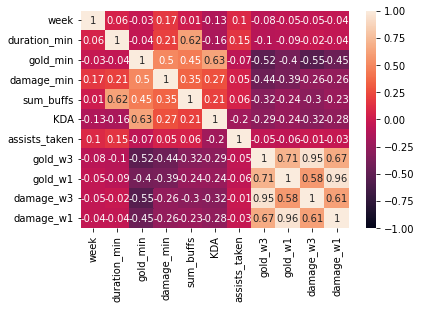

In [84]:
# Verificando correlação entre as variáveis
sns.heatmap(df_new_features.corr().round(2), annot=True, vmin=-1, vmax=1)

###Análise univariada e bivariada de algumas features

In [85]:
# Variável de interesse
target = 'winner'
print('target:', target)

target: winner


In [86]:
# Distribuição da variável "winner"
summary_merged[['winner']].value_counts(sort = False)

winner
0         159
1         159
dtype: int64

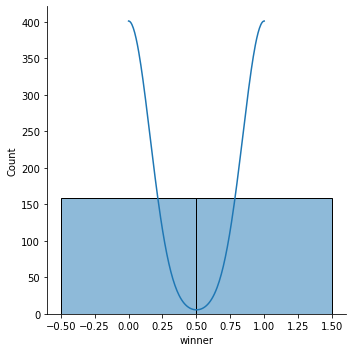

In [87]:
# visualizando a variável "winner"
sns.displot(data=summary_merged, x="winner", kde=True)

Por meio do gráfico, podemos perceber que o nosso dataset é bem balanceado. Temos uma divisão meio a meio da variável de interesse (vencedores e perdedores).

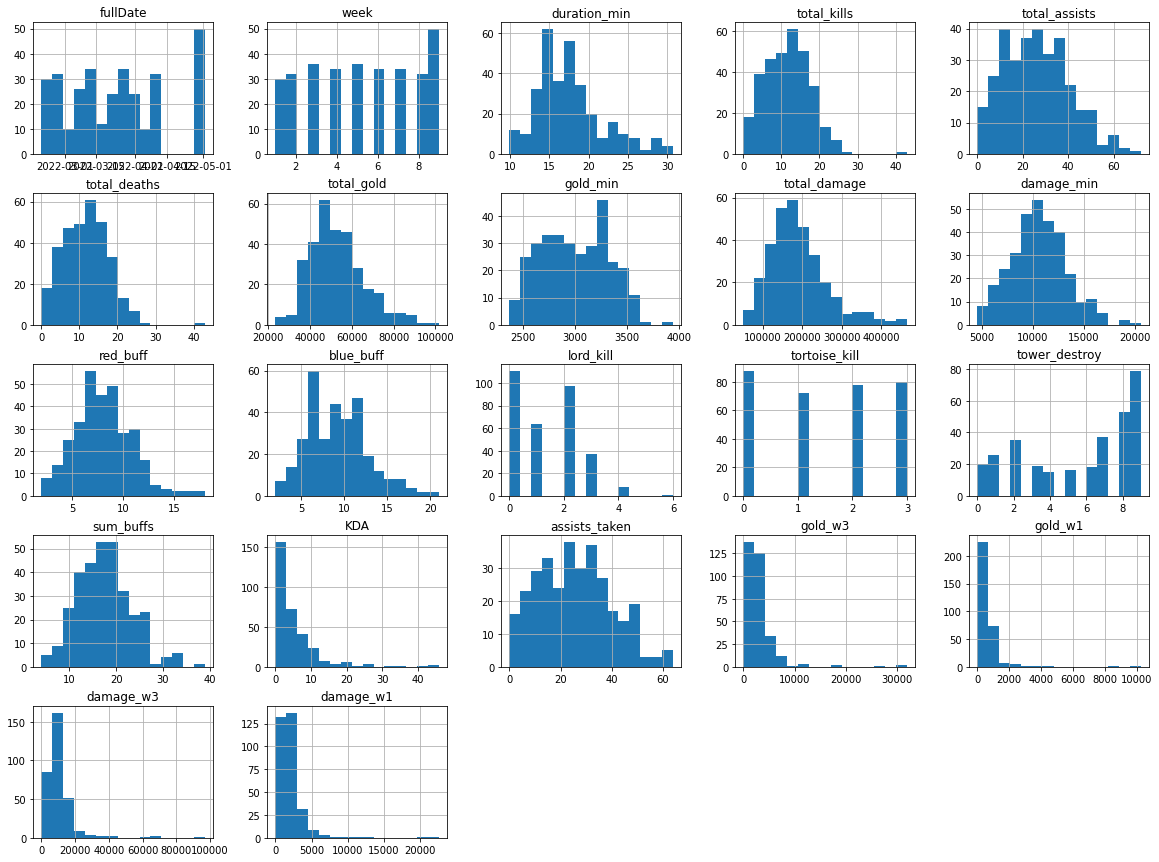

In [88]:
# Histograma das variáveis numéricas
summary_merged.hist(bins=15, figsize=(20,15));

A partir da análise dos histogramas, e da distribuição das frequências de cada variável, podemos tirar as seguintes observações:

a) as distribuições de total_kills e total_assists são conexas como esperado, pois as assistências são participações de outros jogadores na morte de um inimigo. Então, as assistências são as mortes multiplicadas por, no máximo, 5 (quantidade de jogadores do time) e o histograma revela essa distribuição.

b) as distribuições das variáveis total_kills e total_deaths são idênticas, uma vez que são o mesmo valor para cada time alternadamente, já que as mortes causadas por um time são as mortes sofridas pelo outro

c) as distribuições das variáveis total_assists e assists_taken são idênticas, uma vez que são o mesmo valor para cada time alternadamente, já que as assistências causadas por um time são as assistências sofridas pelo outro

d) as distribuições das variáveis que dependem da evolução da partida são normais, com caudas alongadas à direita


In [89]:
#Verificando a cardinalidade das variáveis categóricas
print('Cardinalidade médias das categóricas:', np.mean(summary_merged[vars_cat].nunique()))
summary_merged[vars_cat].nunique().sort_values(ascending=False)

Cardinalidade médias das categóricas: 27.8


id           62
fullDate     62
team_name     8
game          5
winner        2
dtype: int64

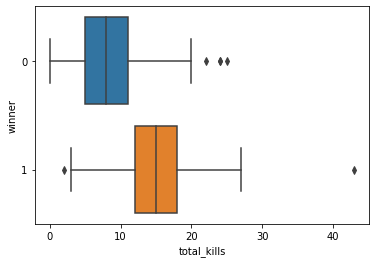

In [90]:
# Relação entre total de mortes provocadas pelo time e vencedor
ax = sns.boxplot(x="total_kills", y="winner", data=summary_merged)

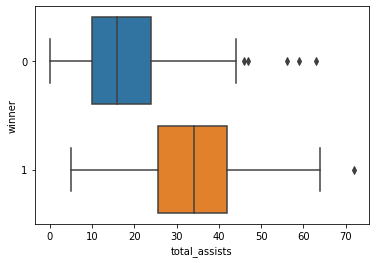

In [91]:
# Relação entre total de assistências e vencedor
ax = sns.boxplot(x="total_assists", y="winner", data=summary_merged)

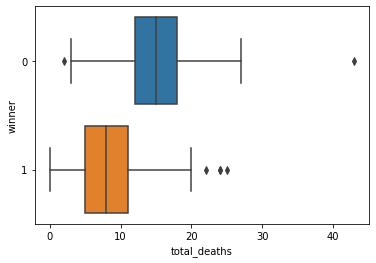

In [92]:
# Relação entre total de mortes sofridas pelo time e vencedor
ax = sns.boxplot(x="total_deaths", y="winner", data=summary_merged)

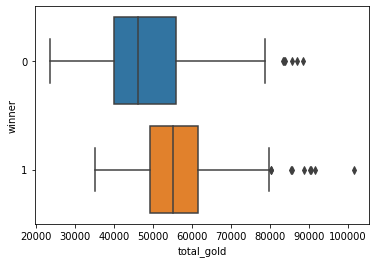

In [93]:
# Relação entre total de ouro adquirido pelos jogadores do time e vencedor
ax = sns.boxplot(x="total_gold", y="winner", data=summary_merged)

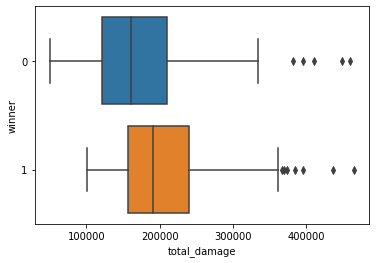

In [94]:
# Relação entre total de dano causado pelos jogadores do time e vencedor
ax = sns.boxplot(x="total_damage", y="winner", data=summary_merged)

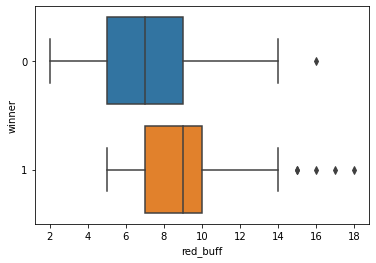

In [95]:
# Relação entre total de monstros da selva do tipo vermelho que o time matou e vencedor
ax = sns.boxplot(x="red_buff", y="winner", data=summary_merged)

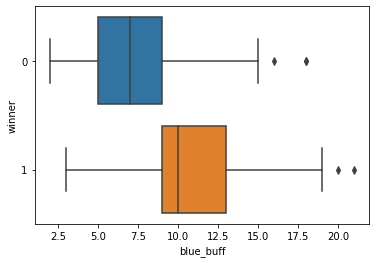

In [96]:
# Relação entre total de monstros da selva do tipo azul que o time matou e vencedor
ax = sns.boxplot(x="blue_buff", y="winner", data=summary_merged)

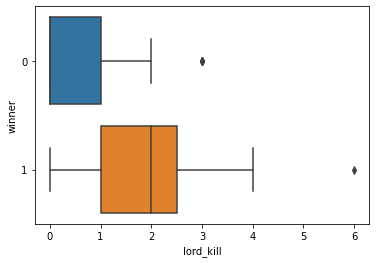

In [97]:
# Relação entre total de lord kill e vencedor
ax = sns.boxplot(x="lord_kill", y="winner", data=summary_merged)

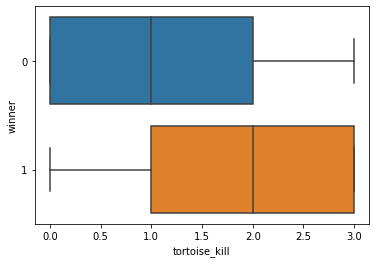

In [98]:
# Relação entre total de tartarugas que o time matou  e vencedor
ax = sns.boxplot(x="tortoise_kill", y="winner", data=summary_merged)

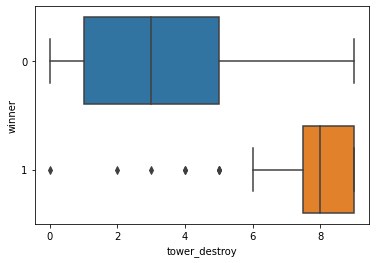

In [99]:
# Relação entre total de lordes que o time matou e vencedor
ax = sns.boxplot(x="tower_destroy", y="winner", data=summary_merged)

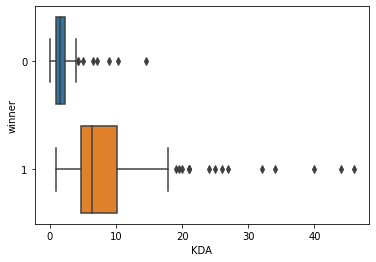

In [100]:
# Relação entre KDA e winner
ax = sns.boxplot(x="KDA", y="winner", data=summary_merged)

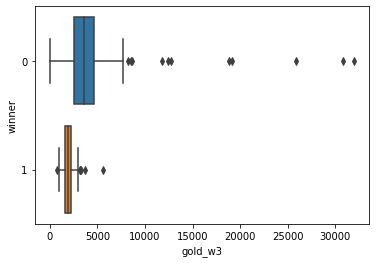

In [101]:
# Relação entre o ouro ponderado para torres e mortes causadas e vencedor
ax = sns.boxplot(x="gold_w3", y="winner", data=summary_merged)

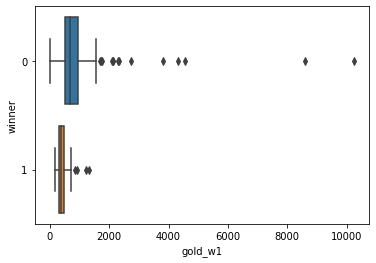

In [102]:
# Relação entre o ouro ponderado para assistências, lordes e tartarugas eliminados e vencedor
ax = sns.boxplot(x="gold_w1", y="winner", data=summary_merged)

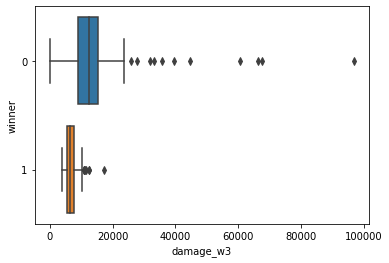

In [103]:
# Relação entre o dano ponderado para torres e mortes causadas e vencedor
ax = sns.boxplot(x="damage_w3", y="winner", data=summary_merged)

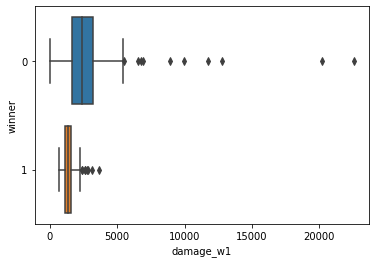

In [104]:
# Relação entre o dano ponderado para assistências, lordes e tartarugas eliminados e vencedor
ax = sns.boxplot(x="damage_w1", y="winner", data=summary_merged)

In [105]:
#Transformando as variáveis textuais para rodar nos modelos
label_encoder = LabelEncoder() 
summary_merged['id_encode'] = label_encoder.fit_transform(summary_merged['id']) 
summary_merged['game_encode'] = label_encoder.fit_transform(summary_merged['game']) 
summary_merged['team_name_encode'] = label_encoder.fit_transform(summary_merged['team_name']) 
summary_merged['fullDate_encode'] = label_encoder.fit_transform(summary_merged['fullDate']) 

In [106]:
#Exportando o dataset depois das modificações
#summary_merged.to_excel('summary_merged.xlsx',index=False)